# Training Report
Clean, reproducible report to inspect training metrics and evaluate the trained model on the test set.

In [1]:
from pathlib import Path
import json
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from dataio import CustomDataset, custom_transform
from models import SimpleCNN, SimpleMLP

# Optional: sklearn metrics if available
try:
    from sklearn.metrics import classification_report, confusion_matrix
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

plt.style.use('seaborn-v0_8')
%matplotlib inline

## Select Run

In [2]:
# Set this to a specific run directory if desired.
RUN_DIR = None  # e.g., Path('../outputs/2025-01-01/12-00-00')

bases = [Path('../trained_models'), Path('../outputs')]
candidates = []
for base in bases:
    if base.exists():
        for d in base.rglob('*'):
            if d.is_dir() and (d / 'metrics.csv').exists():
                candidates.append((d, (d / 'metrics.csv').stat().st_mtime))

if RUN_DIR is None and candidates:
    RUN_DIR = sorted(candidates, key=lambda x: x[1], reverse=True)[0][0]

assert RUN_DIR is not None, 'No run directory with metrics.csv found under ../trained_models or ../outputs'
RUN_DIR = Path(RUN_DIR)
RUN_DIR

PosixPath('../trained_models/weighted_loss')

## Load Metrics

In [3]:
metrics_path = RUN_DIR / 'metrics.csv'
config_path = RUN_DIR / 'config.yaml'
model_path = RUN_DIR / 'model.pth'

metrics = pd.read_csv(metrics_path)
display(metrics.tail(5))

best_by_val_acc = metrics['val_accuracy'].idxmax()
best_by_val_loss = metrics['val_loss'].idxmin()
summary = {
    'final_epoch': int(len(metrics) - 1),
    'final_train_loss': float(metrics['train_loss'].iloc[-1]),
    'final_val_loss': float(metrics['val_loss'].iloc[-1]),
    'final_train_acc': float(metrics['train_accuracy'].iloc[-1]),
    'final_val_acc': float(metrics['val_accuracy'].iloc[-1]),
    'best_val_acc_epoch': int(best_by_val_acc),
    'best_val_acc': float(metrics['val_accuracy'].iloc[best_by_val_acc]),
    'best_val_loss_epoch': int(best_by_val_loss),
    'best_val_loss': float(metrics['val_loss'].iloc[best_by_val_loss]),
}
print(json.dumps(summary, indent=2))

,train_loss,val_loss,train_accuracy,val_accuracy
95,0.003109,0.330998,0.999041,0.9375
96,0.007474,0.762330,0.998466,0.8750
97,0.011191,0.036922,0.998083,1.0000
98,0.010323,0.227932,0.997124,0.9375
99,0.004289,0.768745,0.998466,0.8125


{
  "final_epoch": 99,
  "final_train_loss": 0.0042885669857805,
  "final_val_loss": 0.7687450051307678,
  "final_train_acc": 0.9984662576687116,
  "final_val_acc": 0.8125,
  "best_val_acc_epoch": 3,
  "best_val_acc": 1.0,
  "best_val_loss_epoch": 53,
  "best_val_loss": 0.0025051794946193
}


## Curves

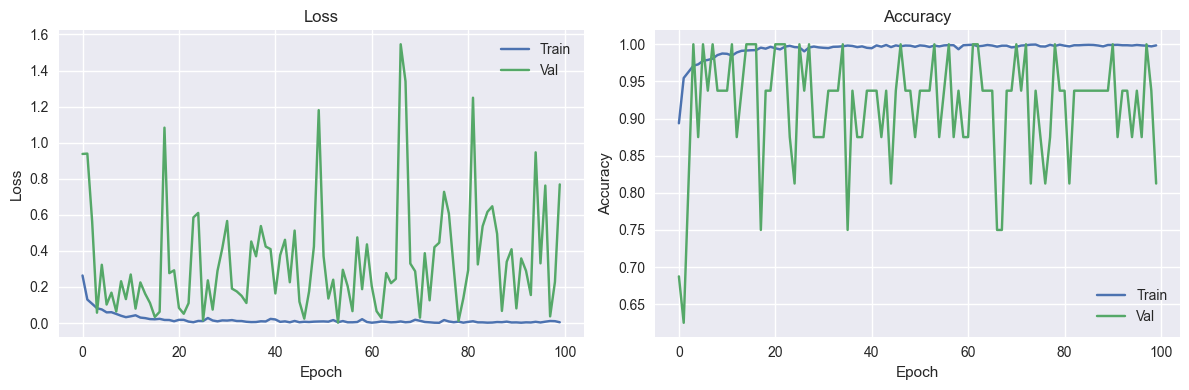

In [4]:
epochs = range(len(metrics))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(epochs, metrics['train_loss'], label='Train')
axes[0].plot(epochs, metrics['val_loss'], label='Val')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epochs, metrics['train_accuracy'], label='Train')
axes[1].plot(epochs, metrics['val_accuracy'], label='Val')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()

## Load Model

In [5]:
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

DEVICE = get_device()
print('Device:', DEVICE)

model_name = config.get('model', 'CNN')
input_size = int(config.get('input_size', 256))
num_classes = 2

if model_name == 'CNN':
    model = SimpleCNN(input_size=input_size, num_classes=num_classes)
elif model_name == 'MLP':
    model = SimpleMLP(input_size=input_size * input_size, num_classes=num_classes)
elif model_name == 'ResNet18':
    from torchvision.models import resnet18
    model = resnet18(weights=None)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = torch.nn.Linear(in_features=512, out_features=num_classes, bias=True)
else:
    raise ValueError(f'Unknown model: {model_name}')

state = torch.load(model_path, map_location='cpu')
model.load_state_dict(state)
model.to(DEVICE)
model.eval()

Device: mps


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=65536, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

## Test Evaluation

Test accuracy: 0.7420 (n=624)
              precision    recall  f1-score   support

      NORMAL       0.96      0.32      0.49       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.80      0.74      0.70       624



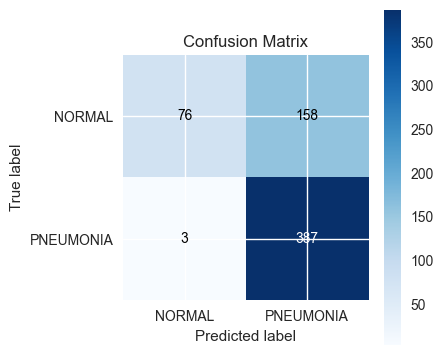

In [6]:
# Build test loader
test_set = CustomDataset(
    path=Path('..') / 'chest_xray',
    split='test',
    transform=custom_transform(input_size=input_size),
)
test_loader = DataLoader(test_set, batch_size=int(config.get('batch_size', 32)), shuffle=False)

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        logits = model(images.to(DEVICE)).cpu()
        preds = logits.argmax(dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
test_acc = (y_true == y_pred).mean()
print(f'Test accuracy: {test_acc:.4f} (n={len(y_true)})')

# Classification report
if SKLEARN_AVAILABLE:
    print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))
else:
    # Basic per-class precision/recall without sklearn
    for cls, name in enumerate(['NORMAL', 'PNEUMONIA']):
        tp = int(((y_pred == cls) & (y_true == cls)).sum())
        fp = int(((y_pred == cls) & (y_true != cls)).sum())
        fn = int(((y_pred != cls) & (y_true == cls)).sum())
        prec = tp / (tp + fp + 1e-9)
        rec = tp / (tp + fn + 1e-9)
        f1 = 2 * prec * rec / (prec + rec + 1e-9)
        print(f'{name:10s}  precision={prec:.3f}  recall={rec:.3f}  f1={f1:.3f}')

# Confusion matrix
def plot_confusion(cm, classes):
    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

if SKLEARN_AVAILABLE:
    cm = confusion_matrix(y_true, y_pred)
else:
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
plot_confusion(cm, ['NORMAL', 'PNEUMONIA'])